In [1]:
import csv
import pandas as pd
from nltk.util import trigrams
from sklearn.utils import murmurhash3_32
from collections import defaultdict
import random
import numpy as np
import matplotlib.pyplot as plt
import time

random.seed(42)

# Task 0

In [2]:
def jaccard_similarity(string1, string2) -> float:
    trig1 = list(trigrams([c for c in string1]))
    trig_str1 = [''.join(x) for x in trig1]
    
    trig2 = list(trigrams([c for c in string2]))
    trig_str2 = [''.join(x) for x in trig2]
    
    return len(set(trig_str1) & set(trig_str2)) / len(set(trig_str1) | set(trig_str2))

In [3]:
def MinHash (input_str: str, m: int, R: int, table: int = 0):
    trigs = list(trigrams([c for c in input_str]))
    res = []
    for i in range(m):
        minhash = float('inf')
        for trig in trigs:
            trig_str = ''.join(trig)
            minhash = min(minhash, murmurhash3_32(trig_str, seed=table*100+i, positive=True) % R)
        res.append(minhash)
    return res

In [4]:
string1 = "The mission statement of the WCSCC and area employers recognize the importance of good attendance on the job. Any student whose absences exceed 18 days is jeopardizing their opportunity for advanced placement as well as hindering his/her likelihood for successfully completing their program."
string2 = "The WCSCC’s mission statement and surrounding employers recognize the importance of great attendance. Any student who is absent more than 18 days will loose the opportunity for successfully completing their trade program."

real_jaccard = jaccard_similarity(string1, string2)
print(real_jaccard)

m = 100
MinHash_str1 = MinHash(string1, m, 2**20)
MinHash_str2 = MinHash(string2, m, 2**20)

MinHash_similarity = sum([1 if MinHash_str1[i] == MinHash_str2[i] else 0 for i in range(m)])/m
print(MinHash_similarity)

0.5228070175438596
0.58


In [5]:
class HashTable():
    def __init__ (self, K = 2, L = 50, B = 64, R = 2**20):
        self.K = K
        self.L = L
        self.B = B
        self.R = R
        self.hash_tables = [defaultdict(list) for _ in range(self.L)]
        self.hash_coeffs = []
                
        for i in range(self.L):
            self.hash_coeffs.append(random.sample(range(10000000), self.K))
            
    def insert (self, hashcodes , id):
        for i in range(self.L):
            bucket = sum([a*b for (a, b) in zip(hashcodes[i], self.hash_coeffs[i])]) % self.R
            self.hash_tables[i][bucket].append(id)
            
    def lookup (self, hashcodes ):
        union_set = set()
        for i in range(self.L):
            bucket = sum([a*b for (a, b) in zip(hashcodes[i], self.hash_coeffs[i])]) % self.R
            union_set |= set(self.hash_tables[i][bucket])
        return list(union_set)

In [6]:
data = pd.read_csv("user-ct-test-collection-01.txt", sep="\t")
all_urllist = data.ClickURL.dropna().unique()
urllist = all_urllist[:10000]

In [7]:
len(urllist)

10000

In [8]:
L = 50
K = 2
R = 2 ** 20

In [9]:
h_table = HashTable()

for url in urllist:
    url_hashcodes = []
    for i in range(L):
        url_hashcodes.append(MinHash(url, K, R, i))
    h_table.insert(url_hashcodes, url)

# Task 1

In [10]:
sample_urls_index = random.sample(range(len(urllist)), 200)

In [11]:

sample_urls_hashcodes = []
for url_index in sample_urls_index:
    sample_url_hashcodes = []
    for i in range(L):
        sample_url_hashcodes.append(MinHash(urllist[url_index], K, R, i))
    sample_urls_hashcodes.append(sample_url_hashcodes)

In [14]:
len(sample_urls_hashcodes)

200

In [15]:
# task 1-1
start = time.time()
avg_jaccard_similarity = []
for i, sample_url_hashcodes in enumerate(sample_urls_hashcodes):
    union_bucket_items = h_table.lookup(sample_urls_hashcodes[i])
    s = 0
    for item in union_bucket_items:
        s += (jaccard_similarity(urllist[sample_urls_index[i]], item))
    avg = s / len(union_bucket_items)
    avg_jaccard_similarity.append(avg)
end = time.time()

In [16]:
# task 1-1 result
jaccard_similarity_url_retrieved = sum(avg_jaccard_similarity)/len(avg_jaccard_similarity)
print("mean Jaccard similarity: ", jaccard_similarity_url_retrieved)

mean Jaccard similarity:  0.24847518065976698


In [17]:
# task 1-2
urls_jaccard_similarity = []
for i, sample_url_hashcodes in enumerate(sample_urls_hashcodes):
    union_bucket_items = h_table.lookup(sample_urls_hashcodes[i])
    url_jaccard_similarity = []
    for item in union_bucket_items:
        url_jaccard_similarity.append(jaccard_similarity(urllist[sample_urls_index[i]], item))
    urls_jaccard_similarity.append(url_jaccard_similarity)
top10_avg_jaccard_similarity = []
for url_jaccard_similarity in urls_jaccard_similarity:
    # there is a possibility that the union bucket has < 10 items
    top10_avg_jaccard_similarity.append(sum(sorted(url_jaccard_similarity, reverse=True)[:10])/min(len(url_jaccard_similarity), 10))

In [29]:
# task 1-2 result
top10_jaccard_similarity_url_retrieved = sum(top10_avg_jaccard_similarity)/len(top10_avg_jaccard_similarity)
print("top 10 Jaccard similarity mean:", top10_jaccard_similarity_url_retrieved)

top 10 Jaccard similarity mean: 0.5287181139486035


In [19]:
# task 1-3 query time
print("total time:", end - start, "sec")
print("time per query", (end - start)/len(sample_urls_hashcodes), "sec")

total time: 45.164732694625854 sec
time per query 0.22582366347312927 sec


# Task 2

In [20]:
start = time.time()
for sample_url_index in sample_urls_index:
    for url in urllist:
        jaccard_similarity(urllist[sample_url_index], url)
end = time.time()
print("total time: ", end-start, "sec")

total time:  58.709702491760254 sec


In [21]:
print("time per query: ", (end-start)/len(sample_urls_index), "sec")

time per query:  0.29354851245880126 sec


In [22]:
expected_time = (end-start)/len(urllist)*len(all_urllist)
print("expected time for whole dataset", expected_time, "sec")

expected time for whole dataset 2218.4635280561447 sec


# Task 3

In [23]:
for K in [2, 3, 4, 5, 6]:
    for L in [20, 50, 100]:
        start = time.time()
        h_table = HashTable(K=K, L=L)
        for url in urllist:
            url_hashcodes = []
            for i in range(L):
                url_hashcodes.append(MinHash(url, K, R, i))
            h_table.insert(url_hashcodes, url)
        
        sample_urls_hashcodes = []
        for url_index in sample_urls_index:
            sample_url_hashcodes = []
            for i in range(L):
                sample_url_hashcodes.append( MinHash(urllist[url_index], K, R, i) )
            sample_urls_hashcodes.append(sample_url_hashcodes)
            
        avg_jaccard_similarity = []
        for i, sample_url_hashcodes in enumerate(sample_urls_hashcodes):
            union_bucket_items = h_table.lookup(sample_urls_hashcodes[i])
            s = 0
            for item in union_bucket_items:
                s += (jaccard_similarity(urllist[sample_urls_index[i]], item))
            avg = s / len(union_bucket_items)
            avg_jaccard_similarity.append(avg)
        end = time.time()
        
        jaccard_similarity_url_retrieved = sum(avg_jaccard_similarity)/len(avg_jaccard_similarity)
        print("K=",K," L=", L," mean jaccard similarity=", jaccard_similarity_url_retrieved)
        print("total time: ", end-start, "sec")
        print("time per query: ", (end-start)/len(sample_urls_index), "sec", "\n")

K= 2  L= 20  mean jaccard similarity= 0.27094560474370044
total time:  35.49544072151184 sec
time per query:  0.1774772036075592 sec 

K= 2  L= 50  mean jaccard similarity= 0.24847518873030106
total time:  70.20072507858276 sec
time per query:  0.3510036253929138 sec 

K= 2  L= 100  mean jaccard similarity= 0.2412613630186805
total time:  100.47575902938843 sec
time per query:  0.5023787951469422 sec 

K= 3  L= 20  mean jaccard similarity= 0.3044444862394347
total time:  27.32562756538391 sec
time per query:  0.13662813782691954 sec 

K= 3  L= 50  mean jaccard similarity= 0.2595584663248303
total time:  67.22969150543213 sec
time per query:  0.33614845752716066 sec 

K= 3  L= 100  mean jaccard similarity= 0.2540646389010666
total time:  106.23549556732178 sec
time per query:  0.5311774778366088 sec 

K= 4  L= 20  mean jaccard similarity= 0.385069539009368
total time:  22.280898571014404 sec
time per query:  0.11140449285507202 sec 

K= 4  L= 50  mean jaccard similarity= 0.2956951623266

# Task 4

In [24]:
# Plot 1
L = 50
j_x = np.linspace(0, 1, 200)
p_x = []
for K in [1, 2, 3, 4, 5, 6, 7]:
    tmp = []
    for x in j_x:
        p = 1-(1-x**K)**L
        tmp.append(p)
    p_x.append(tmp)

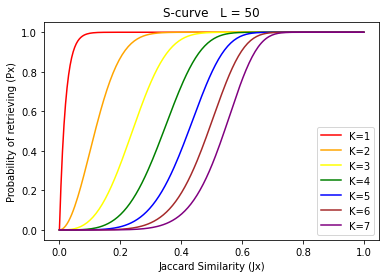

In [25]:
plt.plot(j_x, p_x[0], color = 'red', label='K=1')
plt.plot(j_x, p_x[1], color = 'orange', label='K=2')
plt.plot(j_x, p_x[2], color = 'yellow', label='K=3')
plt.plot(j_x, p_x[3], color = 'green', label='K=4')
plt.plot(j_x, p_x[4], color = 'blue', label='K=5')
plt.plot(j_x, p_x[5], color = 'brown', label='K=6')
plt.plot(j_x, p_x[6], color = 'purple', label='K=7')

plt.xlabel("Jaccard Similarity (Jx)")
plt.ylabel("Probability of retrieving (Px)")
plt.title("S-curve   L = 50")
plt.legend()
plt.show()

In [26]:
# Plot 2
K = 4
j_x = np.linspace(0, 1, 200)
p_x = []
for L in [5, 10, 20, 50, 100, 150, 200]:
    tmp = []
    for x in j_x:
        p = 1-(1-x**K)**L
        tmp.append(p)
    p_x.append(tmp)

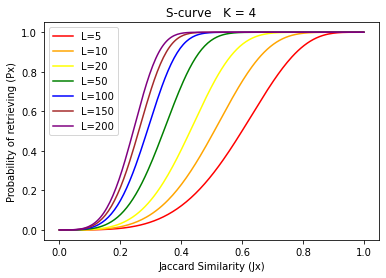

In [27]:
plt.plot(j_x, p_x[0], color = 'red', label='L=5')
plt.plot(j_x, p_x[1], color = 'orange', label='L=10')
plt.plot(j_x, p_x[2], color = 'yellow', label='L=20')
plt.plot(j_x, p_x[3], color = 'green', label='L=50')
plt.plot(j_x, p_x[4], color = 'blue', label='L=100')
plt.plot(j_x, p_x[5], color = 'brown', label='L=150')
plt.plot(j_x, p_x[6], color = 'purple', label='L=200')

plt.xlabel("Jaccard Similarity (Jx)")
plt.ylabel("Probability of retrieving (Px)")
plt.title("S-curve   K = 4")
plt.legend()
plt.show()